# Vehicle Sales Data

## Nội dung
Giao dịch bán ô tô.

## Trường dữ liệu
**year:** Năm sản xuất.\
**make:** Hãng sản xuất.\
**model:** Mẫu xe.\
**trim:** Gói tùy chọn.\
**body:** Dòng xe.\
**transmission:** Loại hộp số ô tô.\
**vin:** Số VIN - Vehicle Identification Number (còn được gọi là số khung) - là số định danh riêng biệt cho từng ô tô .\
**state:** Bang nơi ô tô được đăng ký.\
**condition:** Đánh giá tình trạng xe trên thang điểm 1-49.\
**odometer:** Quãng đường xe đã đi .\
**color:** Màu sắc bên ngoài xe.\
**interior:** Màu sắc bên trong xe.\
**seller:** Người bán.\
**mmr:** Giá bán thị trường dựa theo Manheim Market Report.\
**sellingprice:** Giá bán thực tế.\
**saledate:** Thời gian bán.


## Mục tiêu phân tích
- Phát hiện những yếu tố ảnh hưởng đến giá bán ô tô.
- Xây dựng mô hình dự đoán giá bán ô tô.

## Khai báo thư viện

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from dmba import regressionSummary

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
sns.set_palette("tab10",plt.cm.tab10.N )

## Tiền xử lý

In [2]:
#Đọc dữ liệu
car_transaction = pd.read_csv(r"C:\Users\Anh Huynh\Data Analysis\car_prices.csv")

In [3]:
#5 dòng dữ liệu đầu tiên
car_transaction.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [4]:
#Tổng quan dữ liệu
car_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [5]:
#Tỷ lệ giá trị thiếu tại từng cột
for c in car_transaction.columns:
    missing_values = np.mean(car_transaction[c].isna())
    print(f'{c} - {round(missing_values * 100, 3)}%')

year - 0.0%
make - 1.843%
model - 1.861%
trim - 1.906%
body - 2.361%
transmission - 11.694%
vin - 0.001%
state - 0.0%
condition - 2.115%
odometer - 0.017%
color - 0.134%
interior - 0.134%
seller - 0.0%
mmr - 0.007%
sellingprice - 0.002%
saledate - 0.002%


In [6]:
#Loại bỏ NaN
car_transaction.dropna(inplace = True)

In [7]:
#Kiểm tra lại dữ liệu sau xử lý NaN
car_transaction.shape[0]

472325

In [8]:
#Chuyển đổi cột saledate thành kiểu dữ liệu thời gian
car_transaction.saledate = pd.to_datetime(car_transaction.saledate.str[:-6], utc = True)

In [9]:
#Kiểm tra cột saledate
car_transaction.saledate

0        2014-12-16 20:30:00+00:00
1        2014-12-16 20:30:00+00:00
2        2015-01-15 12:30:00+00:00
3        2015-01-29 12:30:00+00:00
4        2014-12-18 20:30:00+00:00
                    ...           
558831   2015-07-07 13:15:00+00:00
558833   2015-07-08 16:30:00+00:00
558834   2015-07-08 16:30:00+00:00
558835   2015-07-09 13:45:00+00:00
558836   2015-05-28 12:30:00+00:00
Name: saledate, Length: 472325, dtype: datetime64[ns, UTC]

In [10]:
#Chuyển dữ liệu thành kiểu viết thường để tránh trùng lặp
for col in car_transaction:
    if car_transaction[col].dtype == 'object':
        car_transaction[col] = car_transaction[col].str.lower()

In [11]:
#Kiểm tra các giá trị khác biệt
print(car_transaction.color.unique())
print(car_transaction.interior.unique())

['white' 'gray' 'black' 'red' 'silver' 'brown' 'beige' 'blue' 'purple'
 'burgundy' '—' 'gold' 'yellow' 'green' 'charcoal' 'orange' 'off-white'
 'turquoise' 'pink' 'lime']
['black' 'beige' 'tan' 'brown' '—' 'gray' 'burgundy' 'white' 'silver'
 'off-white' 'red' 'yellow' 'green' 'purple' 'blue' 'orange' 'gold']


In [12]:
#Loại bỏ những dòng chứa '—'
error = (car_transaction.color == '—') | (car_transaction.interior == '—')
car_transaction = car_transaction[~error]

## EDA

In [13]:
#Các chỉ số thống kê
car_transaction.describe()

,year,condition,odometer,mmr,sellingprice
count,440393.000000,440393.000000,440393.000000,440393.000000,440393.000000
mean,2010.135484,30.613915,67673.956212,13645.973994,13499.989546
std,3.834401,13.235133,52151.317465,9435.663268,9514.885835
min,1990.000000,1.000000,1.000000,25.000000,1.000000
25%,2008.000000,23.000000,28808.000000,7250.000000,7000.000000
50%,2012.000000,34.000000,52490.000000,12150.000000,12000.000000
75%,2013.000000,41.000000,97900.000000,18050.000000,18000.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


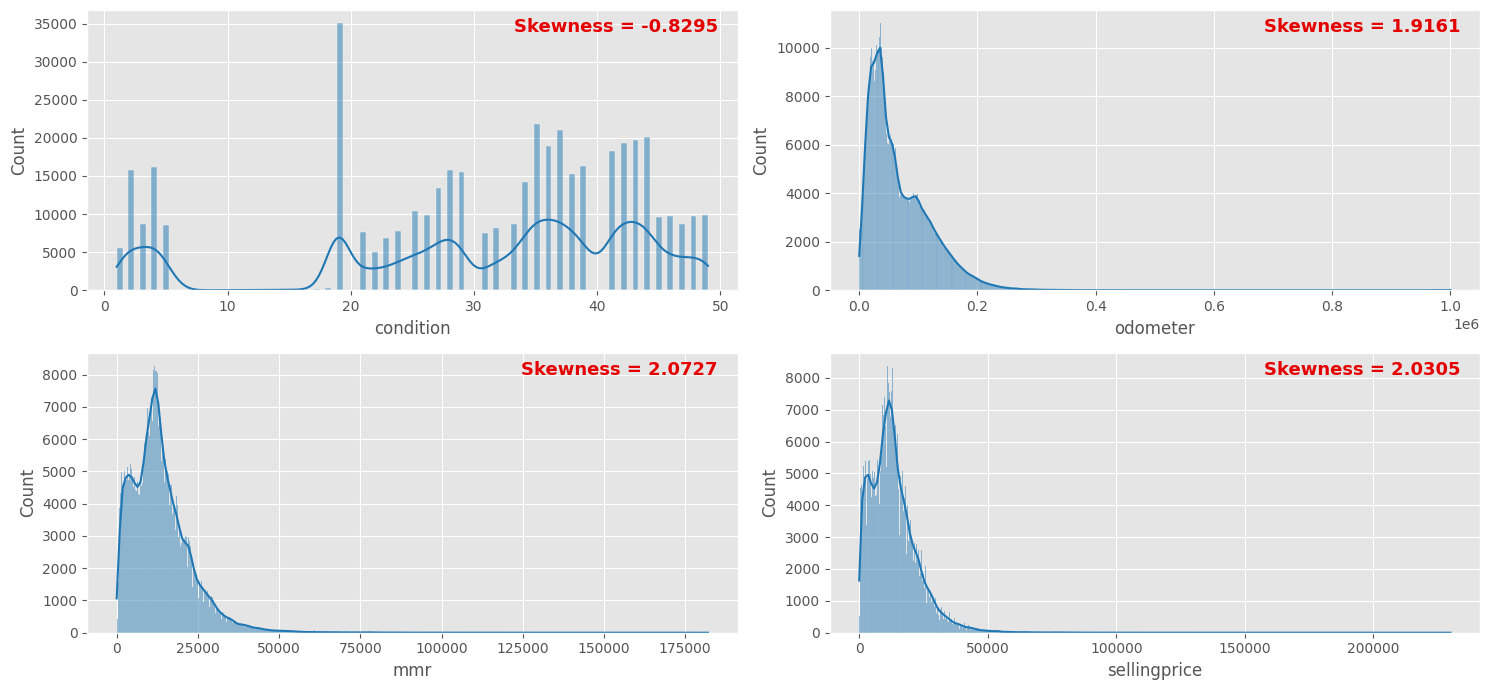

In [14]:
#Phân phối bộ dữ liệu
f, axes = plt.subplots(2, 2, figsize = (15, 7))
sns.histplot(data = car_transaction, x= 'condition', kde = True, ax = axes[0,0])
sns.histplot(data = car_transaction, x= 'odometer', kde = True, ax = axes[0,1])
sns.histplot(data = car_transaction, x= 'mmr', kde = True, ax = axes[1,0])
sns.histplot(data = car_transaction, x= 'sellingprice', kde = True, ax = axes[1,1])

cols = ['condition', 'odometer', 'mmr', 'sellingprice']
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x = 0.97, y = 0.97, transform = ax.transAxes, s = f'Skewness = {stats.skew(car_transaction[cols[i]]).round(4)}', fontweight = 'demibold', fontsize = 13, verticalalignment = 'top', horizontalalignment = 'right', color = 'xkcd:red')
plt.tight_layout()

>Do phân phối của các biến định lượng trên trong bộ dữ liệu đều bị lệch nên mỗi khi cần xác định giá trị trung tâm của chúng, ta sẽ dùng giá trị trung vị thay vì trung bình.

In [15]:
#Những mốc thời gian (năm) thực hiện giao dịch
car_transaction.saledate.dt.year.unique()

array([2014, 2015])

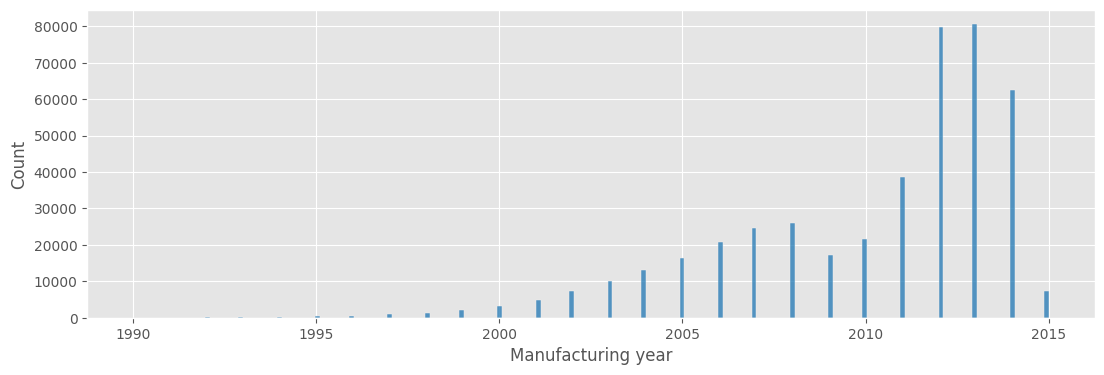

In [16]:
#Số lượng xe được giao dịch theo năm sản xuất
plt.figure(figsize=(13,4))
sns.histplot(data = car_transaction, x= 'year')
plt.xlabel('Manufacturing year')
plt.show()

>Phần nhiều các giao dịch trong bộ dữ liệu là những chiếc xe đã được sản xuất trong khoảng 3 năm trở lại.

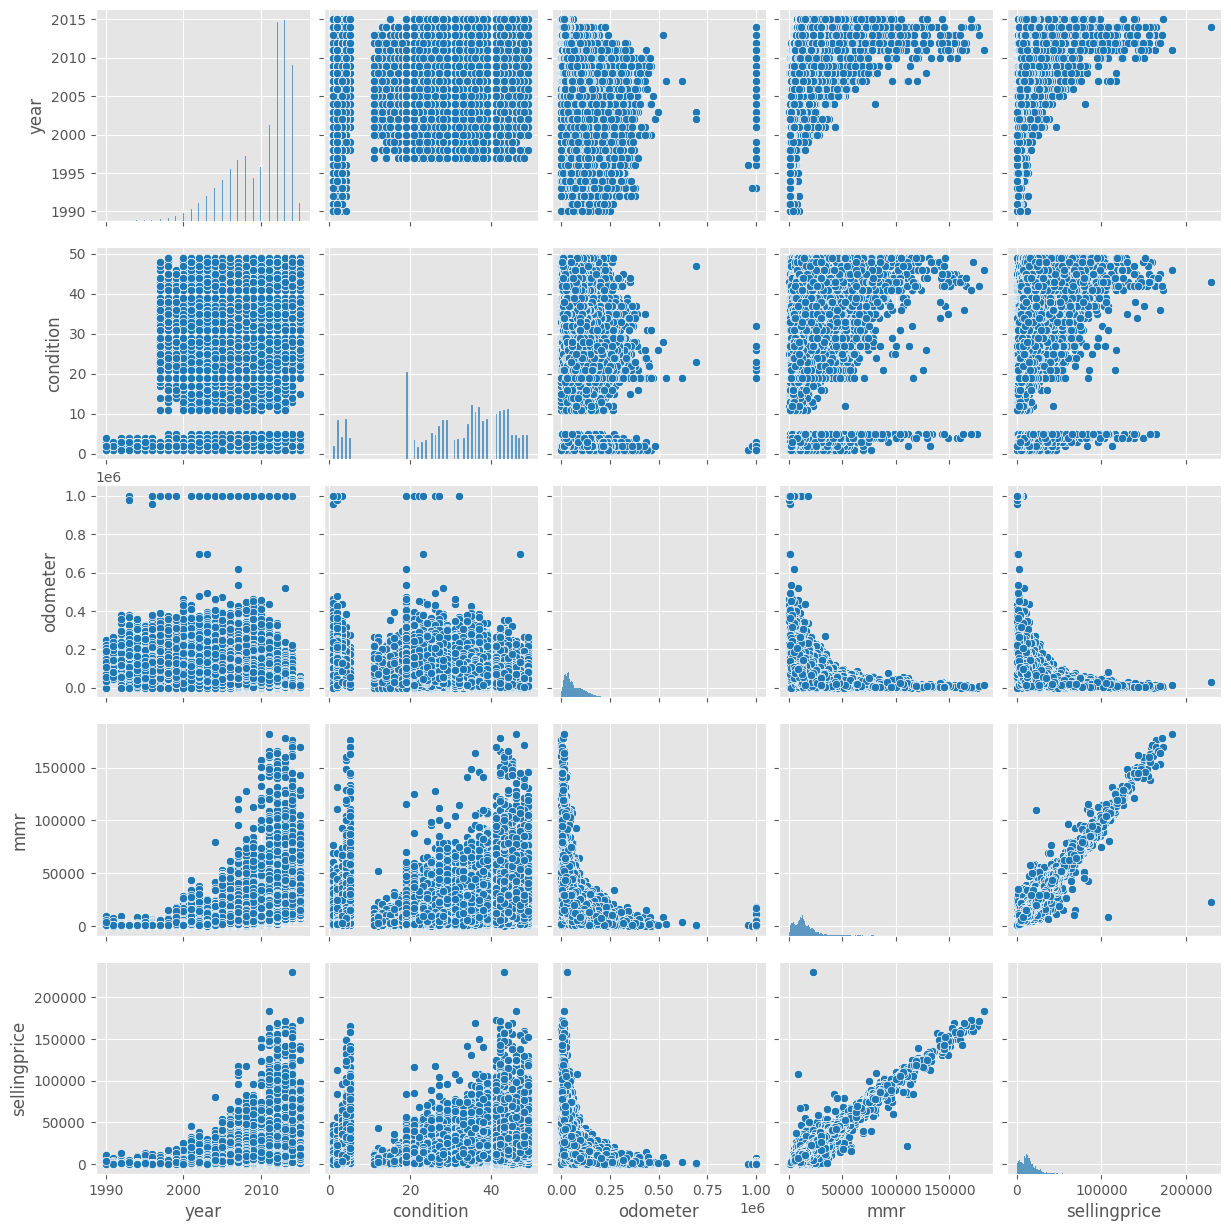

In [17]:
#Scatter plot matrix
sns.pairplot(car_transaction)
plt.show()

>- Giữa giá bán thực tế và giá theo MMR có mối tương quan tuyến tính tỷ lệ thuận mạnh mẽ. Điều này thể hiện các giao dịch trong bộ dữ liệu được thực hiện theo sát với giá thị trường.
>- Quãng đường xe đã đi càng nhiều thì giá bán càng thấp.
>- Những chiếc ô tô được sản xuất từ đầu đến cuối những năm 1990s có giá trao đổi và điểm đánh giá tình trạng nằm ở khoảng thấp nhất trong bộ dữ liệu.
>- Từ khoảng 10 điểm đánh giá trở đi, phần nào ta thấy có chiều hướng rằng những chiếc xe để được bán với giá cao phải có điểm đánh giá tốt. Tuy nhiên, khi dưới mức này vẫn có những chiếc xe được giao dịch với giá cao.
>- Những chiếc xe càng được sản xuất về sau thì giá giao dịch có chiều hướng cao hơn so với giai đoạn trước.

In [18]:
#Hàm vẽ biểu đồ cột
def barplot(field):
    plt.figure(figsize= (15,4))
    car_transaction.groupby(field).sellingprice.median().plot(kind= 'bar')
    plt.ylabel('sellingprice')
    plt.show()

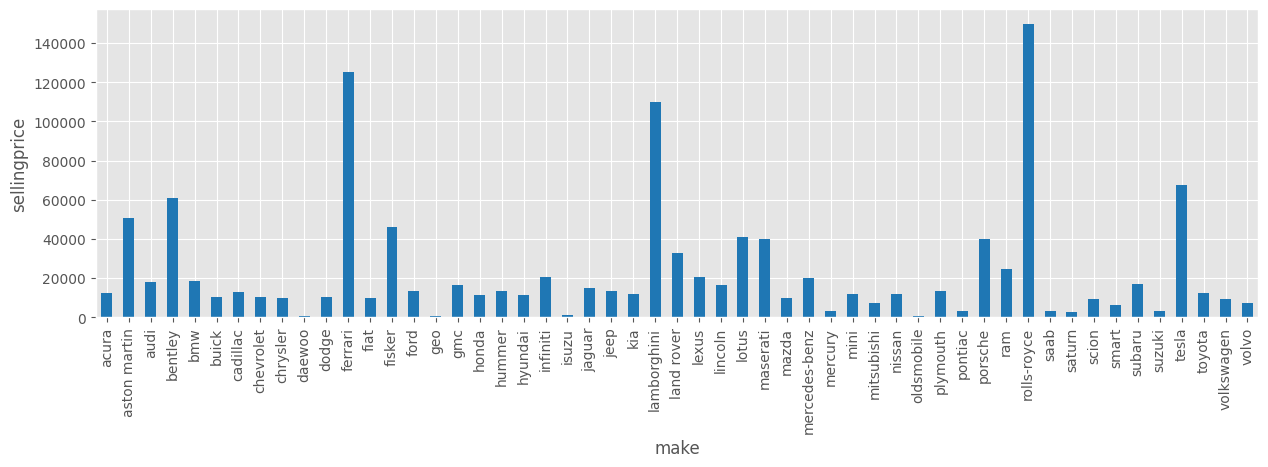

In [19]:
#Giá giao dịch theo hãng
barplot('make')

>Phần lớn các hãng có giá giao dịch dưới 20000, số ít vượt ngưỡng 40000.\
>Ferrari, Lamborghini và Rolls-royce là 3 hãng xe có mức giá giao dịch cao nổi bật so với những hãng khác.

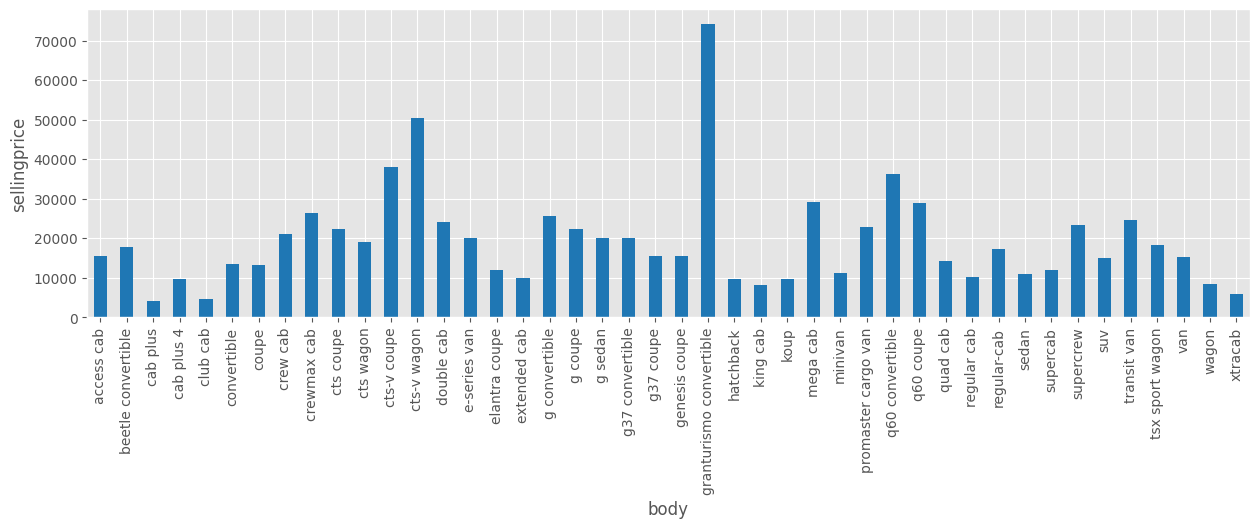

In [20]:
#Giá giao dịch theo dòng xe
barplot('body')

>Phổ biến các dòng xe có giá giao dịch từ dưới 30000.\
>Tuy nhiên, dòng Granturismo Convertible của riêng Maserati có giá giao dịch cao ấn tượng đối với những dòng khác.

In [21]:
#Đếm dữ liệu cột transmission
transmission = car_transaction.transmission.value_counts()

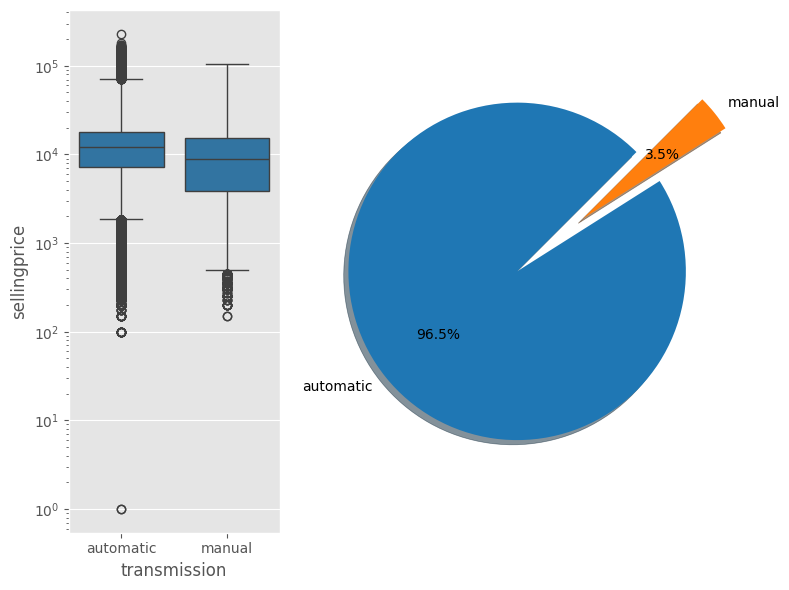

In [22]:
#Giá giao dịch theo loại hộp số và tỷ lệ từng loại trong dữ liệu
fig = plt.figure(figsize=(8,6)) 
grid = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(grid[0])
sns.boxplot(data=car_transaction, x= 'transmission', y= 'sellingprice', log_scale= True, ax= ax0)
ax1 = plt.subplot(grid[1])
ax1.pie(transmission.values, explode= (0, 0.5), labels=transmission.index,autopct= '%.1f%%', shadow=True, startangle= 45)
plt.tight_layout()

>Những chiếc xe có hộp số sàn (manual) có mức giá giao dịch thấp hơn so với những chiếc được trang bị hộp số tự động. Sự chênh lệch này có thể được giải thích bằng việc gần như toàn bộ các chiếc xe đều được trang bị hộp số tự động thay vì hộp số sàn.

In [23]:
#Hàm vẽ boxplot
def box_plot(col, fig):
    plt.figure(figsize= fig)
    sns.boxplot(data=car_transaction, x= col, y= 'sellingprice', log_scale= True)
    plt.show()

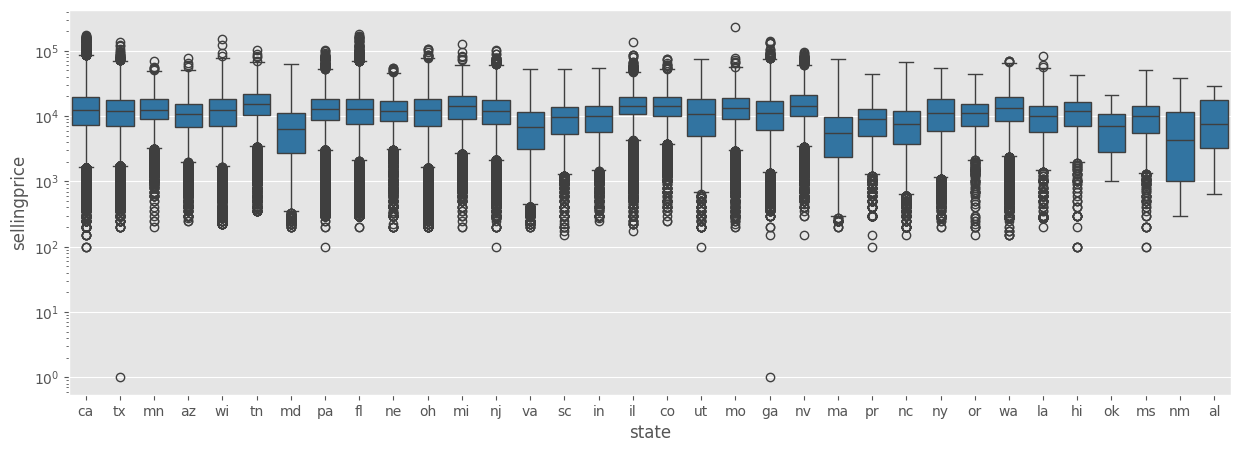

In [24]:
#Giá giao dịch theo bang nơi ô tô đăng ký
box_plot('state', (15,5))

>Một số bang có giá giao dịch thấp hơn so với phần còn lại (như Maryland (MD), Virginia (VA), Massachusetts (MA), Oklahoma (OK), New Mexico (NM)).

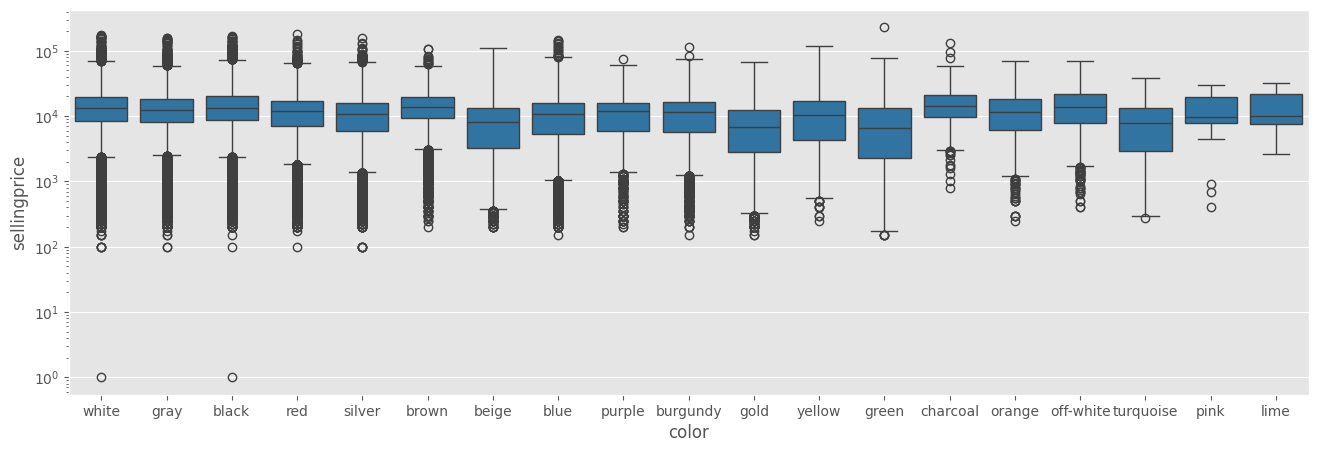

In [25]:
#Giá giao dịch theo màu sắc bên ngoài xe
box_plot('color', (16,5))

>Đối với màu sắc bên ngoài, màu be, vàng kim, xanh lá và ngọc lam có mức giao dịch thấp hơn.

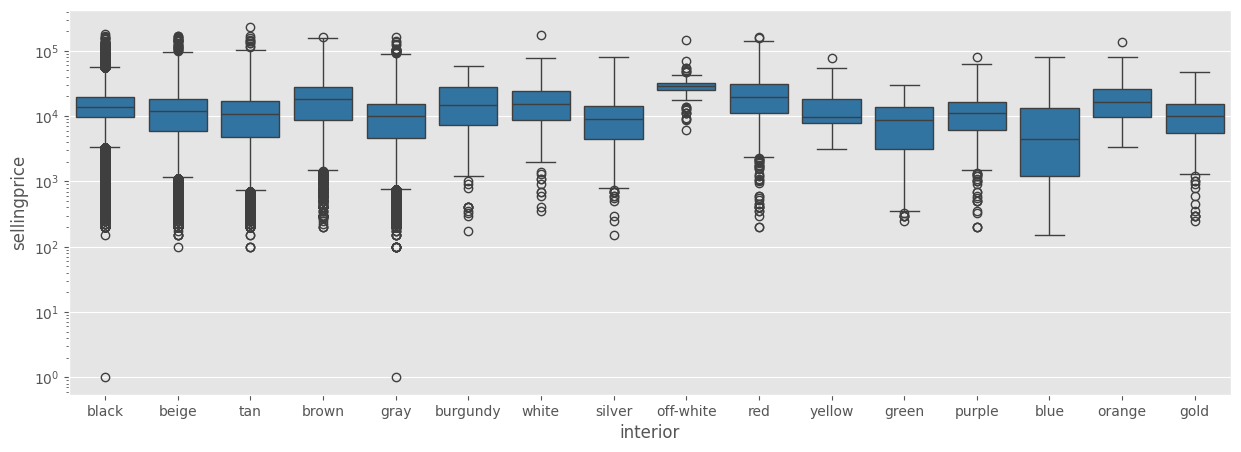

In [26]:
#Giá giao dịch theo màu sắc bên trong xe
box_plot('interior', (15,5))

>Đối với màu sắc bên trong, những chiếc xe có màu trắng nhạt có giá bán cao hơn. Điều ngược lại xảy ra với màu xanh dương.

In [27]:
#Lý giải vì sao có những chiếc xe điểm đánh giá thấp (dưới 10) nhưng giá bán vẫn cao
#Danh sách những hãng có điểm đánh giá tình trạng thấp nhưng giá trao đổi cao
lowcond_highprice = car_transaction[(car_transaction.condition < 10) & (car_transaction.sellingprice >= 100000)]
lowcond_highprice_make = lowcond_highprice.make.unique().tolist()
lowcond_highprice_make

['mercedes-benz',
 'bentley',
 'audi',
 'rolls-royce',
 'land rover',
 'bmw',
 'ferrari',
 'porsche']

In [28]:
check1 = car_transaction[car_transaction.make.isin(lowcond_highprice_make)]

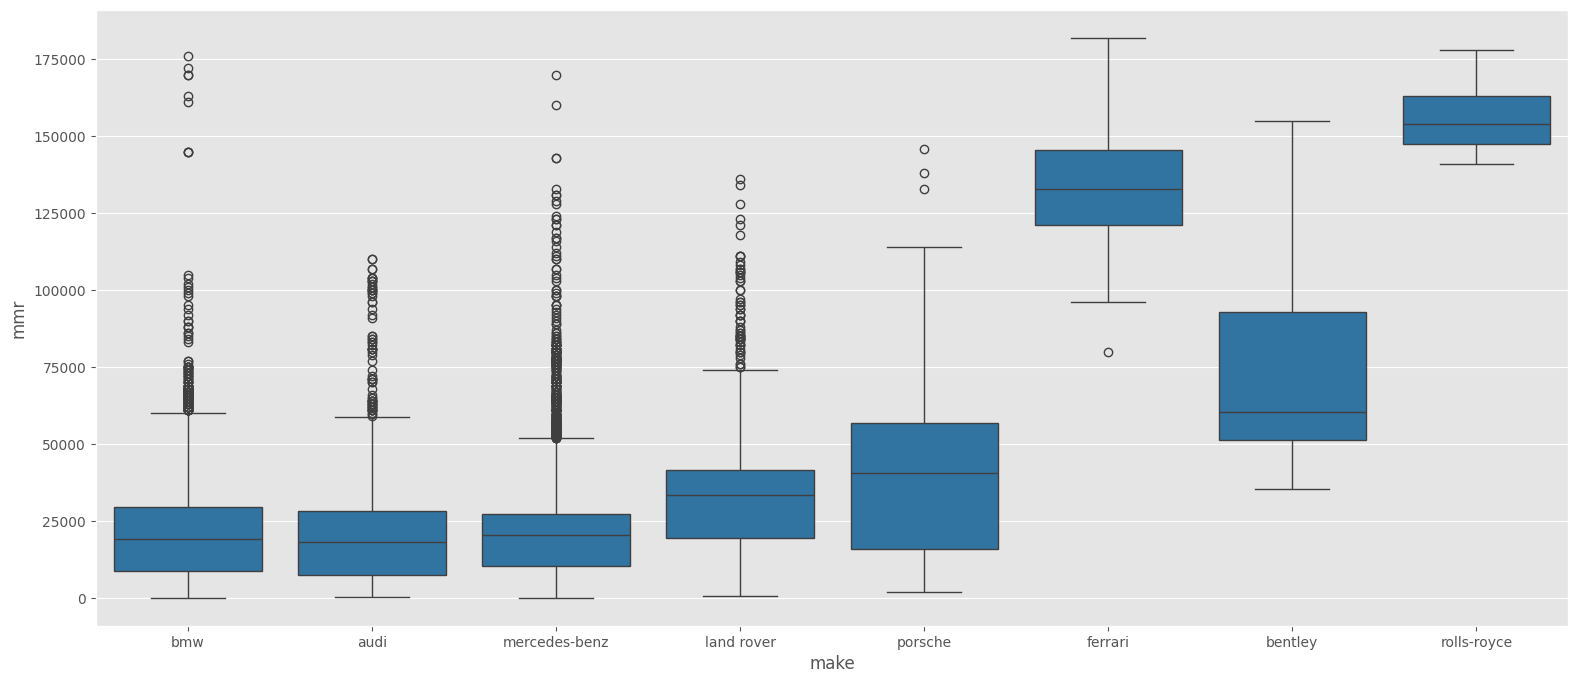

In [29]:
#Giá theo MMR của những hãng có xe điểm thấp - giá bán cao
plt.figure(figsize=(19,8))
sns.boxplot(data=check1, x= 'make', y= 'mmr')
plt.show()

In [30]:
#Danh sách những mẫu xe có điểm đánh giá tình trạng thấp nhưng giá trao đổi cao
lowcond_highprice_model = lowcond_highprice.model.unique().tolist()
lowcond_highprice_model

['g-class',
 'continental gtc',
 'rs 7',
 'ghost',
 's-class',
 'range rover',
 'i8',
 'continental gt',
 'r8',
 'm6',
 'california',
 'sls amg',
 'panamera']

In [31]:
check2 = car_transaction[car_transaction.model.isin(lowcond_highprice_model)]

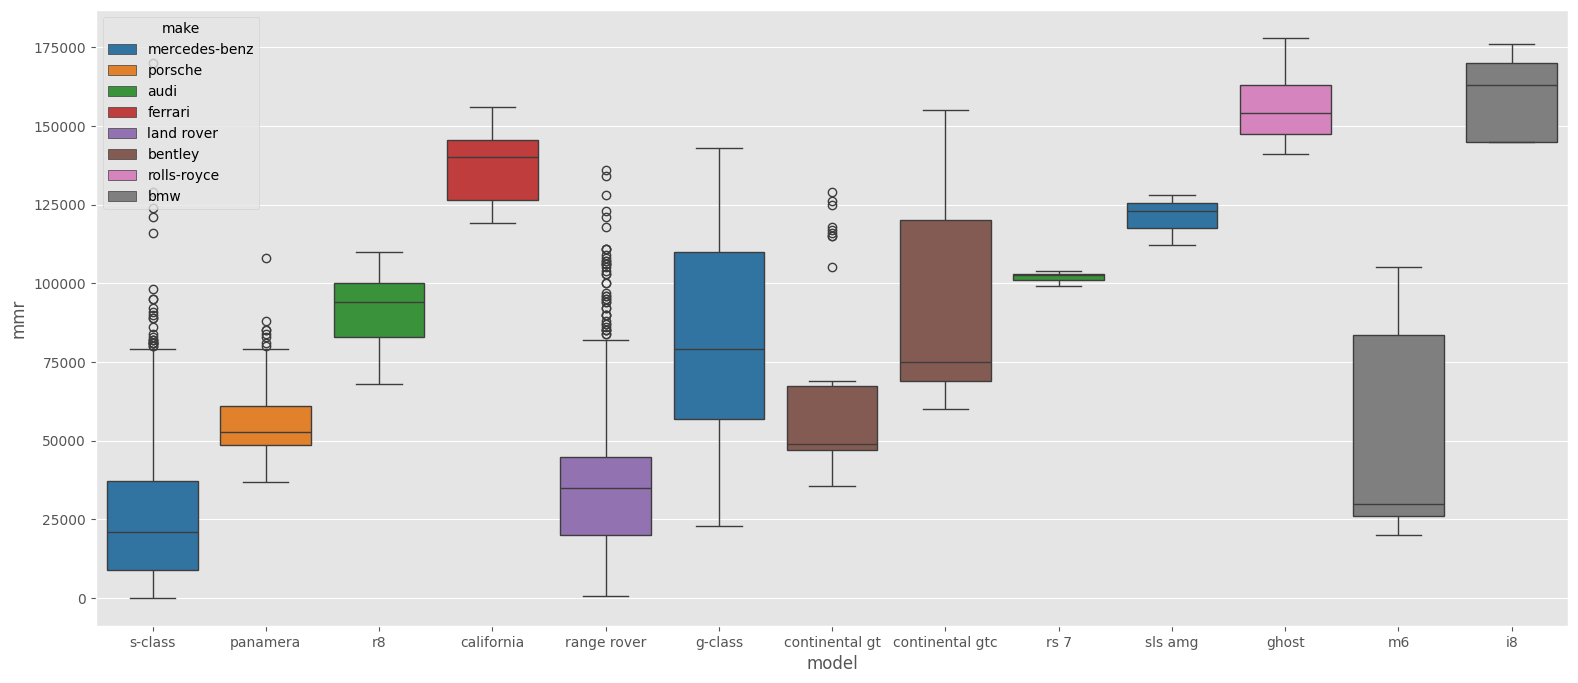

In [32]:
#Giá theo MMR của những mẫu có xe điểm thấp - giá bán cao
plt.figure(figsize=(19,8))
sns.boxplot(data=check2, x= 'model', y= 'mmr', hue='make')
plt.show()

>Tuy có điểm đánh giá tình trạng rất thấp nhưng một số xe vẫn được giao dịch với mức giá cao. Một trong những lý do cho việc này là bởi có những hãng xe vốn luôn được định giá cao trên thị trường (dựa theo MMR), ví dụ như Ferrari hay Rolls-royce. Điều tương tự cũng xảy ra cho một số mẫu xe (rs 7 của Audi, sls amg của mercedes-benz, i8 của bmw).

## Xây mô hình
Xây dựng mô hình dự đoán giá bán bằng thuật toán hồi quy tuyến tính đa biến.

In [33]:
#Chọn biến độc lập và biến phụ thuộc
predictors = ['year', 'make', 'body', 'transmission', 'state', 'condition','odometer', 'color', 'interior', 'mmr']
outcome = 'sellingprice'

#Tạo biến giả
X = pd.get_dummies(car_transaction[predictors], drop_first= True, dtype= float)
Y = car_transaction[outcome]

#Rescaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)

#Phân chia tập dữ liệu
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [34]:
pd.options.display.float_format = '{:.2f}'.format

In [35]:
#Mô hình được xây dựng
model = LinearRegression()
model.fit(train_x, train_y)
print(pd.DataFrame({'Predictor' : X.columns, 'Coefficient' : model.coef_}))

             Predictor  Coefficient
0                 year     -1234.55
1            condition      1821.41
2             odometer     -1628.94
3                  mmr    178251.12
4    make_aston martin      1548.70
..                 ...          ...
161       interior_red       438.65
162    interior_silver         7.92
163       interior_tan       -10.47
164     interior_white       491.90
165    interior_yellow       374.69

[166 rows x 2 columns]


In [36]:
#Kiểm tra hiệu suất mô hình
model_prediction = model.predict(valid_x)
result = pd.DataFrame({'Predicted' : model_prediction, 'Actual' : valid_y, 'Residuals' : valid_y - model_prediction, 'Percent_Error' : np.abs(valid_y - model_prediction)/valid_y * 100})
print(result.head(10))

regressionSummary(valid_y, model_prediction)

        Predicted   Actual  Residuals  Percent_Error
524232   17376.65 19500.00    2123.35          10.89
221899   11879.57 12400.00     520.43           4.20
226481   18173.16 16900.00   -1273.16           7.53
197948   24790.79 24800.00       9.21           0.04
539651    8806.53  8200.00    -606.53           7.40
300159    6092.76  5200.00    -892.76          17.17
359710   19086.34 20700.00    1613.66           7.80
552936   15996.90 16100.00     103.10           0.64
137500   23288.03 22000.00   -1288.03           5.85
459543   10521.64 10500.00     -21.64           0.21

Regression statistics

                      Mean Error (ME) : 2.2041
       Root Mean Squared Error (RMSE) : 1597.7421
            Mean Absolute Error (MAE) : 1020.3480
          Mean Percentage Error (MPE) : -35.6826
Mean Absolute Percentage Error (MAPE) : 46.9682


>Xem xét tổng thể, trung bình khoảng sai số dự đoán của mô hình với giá trị thực tế (MAE) là 1020 và trung bình tỷ lệ sai số so với giá trị thực tế (MAPE) là 46%. Với giá trị MAPE nằm trong khoảng 21%-50% nên khả năng dự đoán của mô hình ở mức có thể chấp nhận được.

In [37]:
#Chi tiết phần trăm sai số giá trị dự đoán
result.Percent_Error.describe(percentiles=[.25,.5,.75,.85,.90,.94,.95,.99])

count     88079.00
mean         46.97
std        7366.55
min           0.00
25%           2.63
50%           6.26
75%          13.81
85%          21.90
90%          30.57
94%          45.65
95%          52.02
99%         152.81
max     2060141.49
Name: Percent_Error, dtype: float64

>Xem xét chi tiết, với 85% dữ liệu xác thực, sai số dự đoán của mô hình ở khoảng 20% trở xuống. Chỉ với khoảng 5% dữ liệu xác thực thì mô hình mới có sai sót dự đoán trên 50%. Với góc nhìn này, ta thấy rằng hiệu suất dự đoán của mô hình là khá tốt.

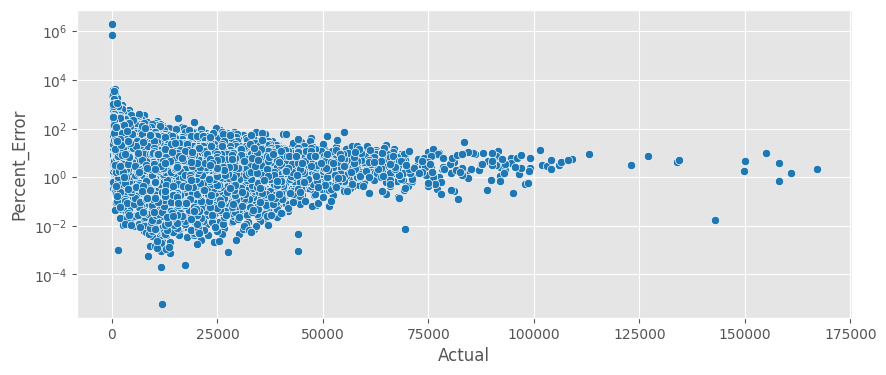

In [38]:
#Scatter plot giá trị thực tế và phần trăm sai số
plt.figure(figsize=(10,4))
sns.scatterplot(data=result, x='Actual', y='Percent_Error')
plt.yscale('log')